In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore")

%matplotlib inline

In [2]:
class Model:
    def __init__(self):
        self.layers = []
        self.input_layer = None
        self.loss = None

    def add(self, layer):
        self.layers.append(layer)

    def set(self, loss):
        self.loss = loss

    def fit(self, X, y, epochs=1, learning_rate=0.01, print_every=1):
        """
        Тренируем нашу сеть на выборке Х, y
        :param epochs: Количество эпох
        :param print_every: Как часто печатаем лог
        :param learning_rate - шаг коррекции весов
        :return:
        """
        errors = []
        for epoch in range(1, epochs + 1):
            output = self.forward(X)

            # Костыль для backpropagation
            # TODO сделать через backward
            error = y - output
            errors.append(np.mean(np.abs(error)))
            for layer in self.layers[::-1]:
                # если текущий слой - активационный
                if hasattr(layer, 'derive'):
                    layer_delta = error * layer.derive(layer.output)
                    error = layer_delta.dot(layer.prev.weights.T)
                    # обновляем веса
                    layer.prev.weights += layer.prev.input.T.dot(layer_delta) * learning_rate

                else:
                    continue

            if epoch % print_every == 0:
                print(f"Loss on epoch {epoch}: {self.loss.calculate(output, y)}")
        return errors

    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X):
        return np.round(self.forward(X))

    def finalize(self):
        self.input_layer = LayerInput()
        layer_count = len(self.layers)

        # Проходимся по слоям и для каждого создаем атрибуты prev, next указывающие
        # на предыдущий и следующий слой соответственно
        for i in range(layer_count):
            if i == 0:
                # Если первый слой - то для него предыдущим будет входной
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i + 1]
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.layers[i + 1]
            else:
                # Здесь замыкающим будет Loss функция
                self.layers[i].prev = self.layers[i - 1]
                self.layers[i].next = self.loss

    def forward(self, X):
        # TODO Проверка на существование input_layer
        self.input_layer.forward(X)

        for layer in self.layers:
            layer.forward(layer.prev.output)

        return layer.output

In [3]:
class LayerInput:
    """
    Dummy класс для создания единообразия с прочими слоями. Содержит входные значения
    """

    def __init__(self):
        self.output = None

    def forward(self, inputs):
        self.output = inputs

In [4]:
class LayerDense:
    """
    Класс полносвязанной слоя. В init'e инициализируем веса рандомно в нормальном
    распределении со стандартным отклонением sigma. Bias инициализируем нулями
    """

    def __init__(self, n_inputs, n_neurons, sigma=0.1):
        self.weights = sigma * np.random.randn(n_inputs, n_neurons)
        # self.biases = np.zeros((1, n_neurons))
        self.output = None
        self.input = None

    def forward(self, inputs):
        """
        Шаг прямого распространения - скалярно перемножаем веса на входные значения плюс смещение.
        """
        self.input = inputs
        self.output = np.dot(inputs, self.weights) #+ self.biases

In [5]:
class ActivationReLU:
    """
    Функция активации ReLU. Выглядит как f(x) = max(0, x)
    """

    def __init__(self):
        self.output = None

    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

    @staticmethod
    def derive(inputs):
        """
        "Производная" функции ReLU.
        """
        return np.where(inputs > 0, 1, 0)

In [6]:
class ActivationSigmoid:
    """
    Функция активации Sigmoid. Выглядит как f(x) = 1 / (1 + exp(-x))
    """

    def __init__(self):
        self.output = None

    def forward(self, inputs):
        self.output = 1 / (1 + np.exp(-inputs))

    @staticmethod
    def derive(inputs):
        """
        Производная Sigmoid
        """
        return inputs * (1 - inputs)

In [7]:
class LossMeanSquaredError:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        return np.mean(sample_losses)

    @staticmethod
    def forward(y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred) ** 2, axis=-1)
        return sample_losses

In [8]:
def to_one_hot(input_y):
    n_col = np.amax(input_y) + 1
    binarized = np.zeros((len(input_y), n_col))
    for i in range(len(input_y)):
        binarized[i, input_y[i]] = 1.
    return binarized


def normalize(X, axis=-1, order=2):
    l2 = np.atleast_1d(np.linalg.norm(X, order, axis))
    l2[l2 == 0] = 1
    return X / np.expand_dims(l2, axis)

In [9]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
target_df = iris.target

In [10]:
x = normalize(iris_df.values)
y = to_one_hot(target_df.flatten())
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [11]:
# TODO сделать функцию обнуления весов
batch_errors = []
for _ in range(10):
    nn_model = Model()
    nn_model.add(LayerDense(4, 5))
    nn_model.add(ActivationSigmoid())
    nn_model.add(LayerDense(5, 4))
    nn_model.add(ActivationSigmoid())
    nn_model.add(LayerDense(4, 3))
    nn_model.add(ActivationSigmoid())
    nn_model.set(
        loss=LossMeanSquaredError()
    )
    nn_model.finalize()

    errors = nn_model.fit(X_train, y_train, learning_rate=0.01, epochs=25000, print_every=25000)
    batch_errors.append(errors)

Loss on epoch 25000: 0.013260664106547524
Loss on epoch 25000: 0.013548583994203656
Loss on epoch 25000: 0.012563725605526939
Loss on epoch 25000: 0.013430656309074982
Loss on epoch 25000: 0.013335438506993404
Loss on epoch 25000: 0.013203681668713487
Loss on epoch 25000: 0.013063958277622054
Loss on epoch 25000: 0.013037753311579683
Loss on epoch 25000: 0.01342205234821403
Loss on epoch 25000: 0.01319113222322532


In [12]:
colors = [
    "b",
    "g",
    "r",
    "c",
    "m",
    "y",
    "k",
    "orange",
    "pink",
    "brown"
]

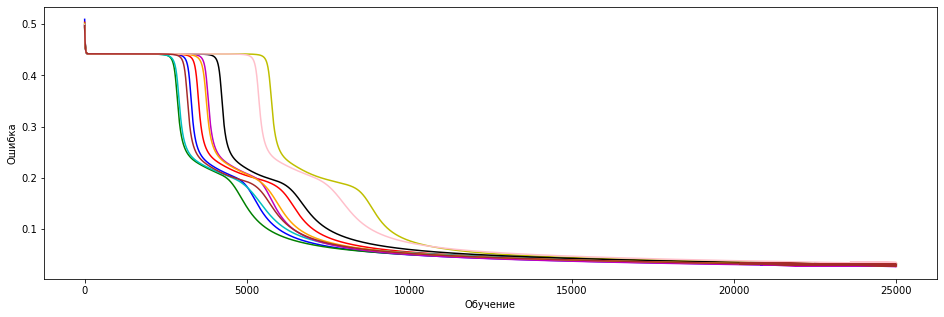

Аккуратность нейронной сети 96.908%


In [13]:
plt.figure(figsize = (16,5))
for i, err in enumerate(batch_errors):
    plt.plot(err, color=colors[i])
    

plt.xlabel('Обучение')
plt.ylabel('Ошибка')
plt.show()

print(f"Аккуратность нейронной сети {(1 - errors[-1]) * 100:.3f}%")

In [14]:
y_pred = nn_model.predict(X_test)
acc = (1 - np.mean(np.abs((y_test - y_pred)))) * 100
print(f"Аккуратность нейронной сети на тесте: {acc:.3f}%")

Аккуратность нейронной сети на тесте: 98.667%
